<a href="https://colab.research.google.com/github/Tounsix/Nike-embeddings-assignment/blob/main/script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gensim -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 75.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 15.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.2
    Uninstalling scipy-1.15.2:
      Successfully uninstalled scipy-1.15.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import re
from gensim.models import Word2Vec
import urllib.request
import zipfile
import os
import warnings

In [ ]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Load the dataset
df = pd.read_csv('NikeProductDescriptions.csv')

In [ ]:
# Display general statistics about the dataset
print("Dataset Overview:")
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")
print("\nColumn Names:")
print(df.columns.tolist())

Dataset Overview:
Number of rows: 400
Number of columns: 3

Column Names:
['Title', 'Subtitle', 'Product Description']


In [ ]:
df.head()

,Title,Subtitle,Product Description
0,Nike Air Force 1 '07,Men's Shoes,It doesn't get more legendary than this. Desig...
1,Nike Air Max Dawn SE,Men's Shoes,Find out what moves you with the Air Max Dawn....
2,Nike SB Dunk Low Pro Premium,Skate Shoes,Pack your style—on your feet. Bringing a fresh...
3,Nike Air Force 1 Mid '07 LX,Men's Shoes,The celebrations just keep coming. Unbox the A...
4,Nike Air Force 1 Mid '07,Men's Shoes,"Got your fave colour yet? No worries, the Colo..."


In [ ]:
df.info()
df.describe(include='all')
df['Subtitle'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Title                400 non-null    object
 1   Subtitle             400 non-null    object
 2   Product Description  400 non-null    object
dtypes: object(3)
memory usage: 9.5+ KB


,count
Subtitle,
Women's Shoes,34
Men's Shoes,31
Skate Shoes,22
Men's T-Shirt,14
Older Kids' T-Shirt,9
...,...
Women's Logo Leggings,1
Women's High-Waisted Wide-Leg Terry Trousers,1
Women's Brief-Lined Running Shorts,1


In [ ]:
df.isnull().sum()

,0
Title,0
Subtitle,0
Product Description,0


In [ ]:
# Filter the dataset according to specified subtitles
target_subtitles = ["Men's Shoes", "Men's T-Shirt", "Women's Shoes", "Skate Shoes", "Older Kids' T-Shirt"]
# Create a copy to avoid SettingWithCopyWarning
df_filtered = df.copy()
# Filter rows with subtitles in target_subtitles or containing "Shorts"
mask = df_filtered['Subtitle'].isin(target_subtitles) | df_filtered['Subtitle'].str.contains('Shorts', case=False, na=False)
df_filtered = df_filtered[mask].copy()

In [ ]:
df_filtered['Subtitle'].value_counts()

,count
Subtitle,
Women's Shoes,34
Men's Shoes,31
Skate Shoes,22
Men's T-Shirt,14
Older Kids' T-Shirt,9
Women's Running Shorts,4
Older Kids' Football Shorts,3
Older Kids' (Boys') Training Shorts,2
Men's Mesh Shorts,2


In [ ]:
# Rename subtitles containing "Shorts" to just "Shorts"
df_filtered.loc[df_filtered['Subtitle'].str.contains('Shorts', case=False, na=False), 'Subtitle'] = 'Shorts'
df_filtered['Subtitle'].value_counts()

,count
Subtitle,
Shorts,45
Women's Shoes,34
Men's Shoes,31
Skate Shoes,22
Men's T-Shirt,14
Older Kids' T-Shirt,9


In [ ]:
# Text preprocessing function
def preprocess_text(text):
    if pd.isna(text):
        return []

    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]

    return tokens


In [ ]:
# Apply preprocessing to descriptions
df_filtered['processed_tokens'] = df_filtered['Product Description'].apply(preprocess_text)
df_filtered['processed_text'] = df_filtered['processed_tokens'].apply(lambda x: ' '.join(x))

In [ ]:
# 1. Bag of Words (BOW) Embedding
print("\nCreating BOW embeddings...")
bow_vectorizer = CountVectorizer(max_features=100)
bow_matrix = bow_vectorizer.fit_transform(df_filtered['processed_text'])
bow_df = pd.DataFrame(bow_matrix.toarray(), columns=bow_vectorizer.get_feature_names_out())



Creating BOW embeddings...


In [ ]:
# 2. TF-IDF Embedding
print("Creating TF-IDF embeddings...")
tfidf_vectorizer = TfidfVectorizer(max_features=100)
tfidf_matrix = tfidf_vectorizer.fit_transform(df_filtered['processed_text'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# 3. Word2Vec Embedding
print("Training Word2Vec model...")
w2v_model = Word2Vec(df_filtered['processed_tokens'], vector_size=100, window=5, min_count=2, workers=4)

# Function to get document embedding from Word2Vec model
def get_doc_vector(doc_tokens, model, vector_size=100):
    vec = np.zeros(vector_size)
    count = 0
    for word in doc_tokens:
        if word in model.wv:
            vec += model.wv[word]
            count += 1
    if count > 0:
        vec /= count
    return vec

# Apply Word2Vec to get document embeddings
df_filtered['w2v_embedding'] = df_filtered['processed_tokens'].apply(
    lambda x: get_doc_vector(x, w2v_model)
)
w2v_matrix = np.vstack(df_filtered['w2v_embedding'].values)

Creating TF-IDF embeddings...
Training Word2Vec model...


In [ ]:
glove_file = 'glove.6B.100d.txt'

In [ ]:
# Load GloVe embeddings
glove_embeddings = {}
with open(glove_file, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.array(values[1:], dtype='float32')
        glove_embeddings[word] = vector

# Function to get document embedding from GloVe
def get_glove_vector(doc_tokens, embeddings, vector_size=100):
    vec = np.zeros(vector_size)
    count = 0
    for word in doc_tokens:
        if word in embeddings:
            vec += embeddings[word]
            count += 1
    if count > 0:
        vec /= count
    return vec

# Apply GloVe to get document embeddings
df_filtered['glove_embedding'] = df_filtered['processed_tokens'].apply(
    lambda x: get_glove_vector(x, glove_embeddings)
)
glove_matrix = np.vstack(df_filtered['glove_embedding'].values)


Performing PCA and visualization...


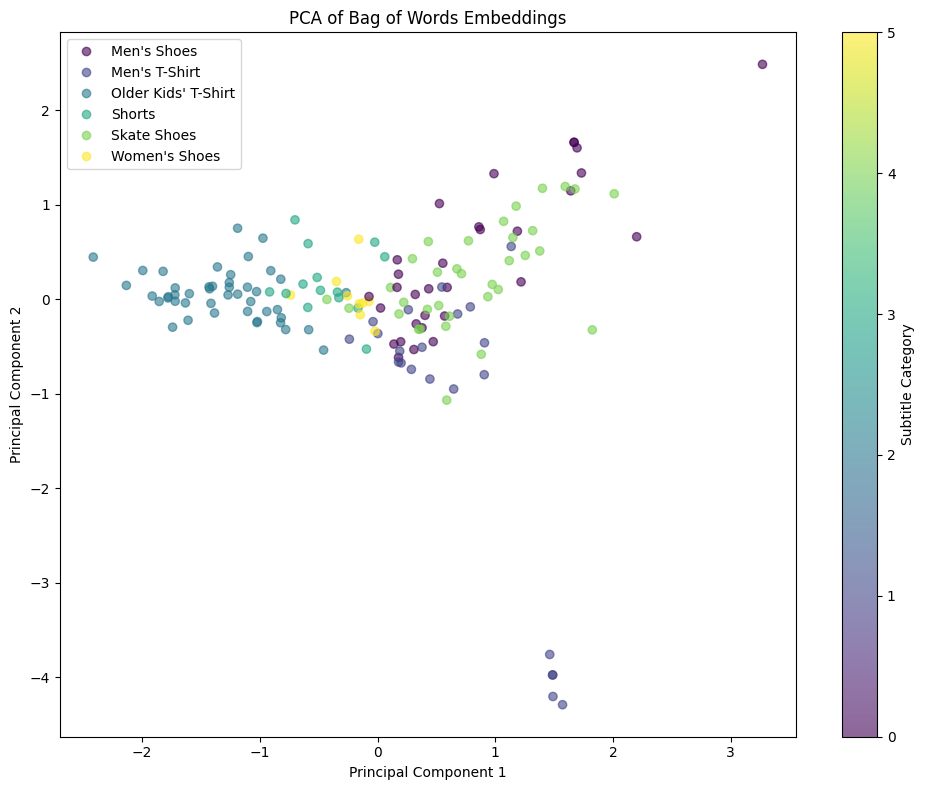

Bag of Words - Variance explained by first two components: 17.56%


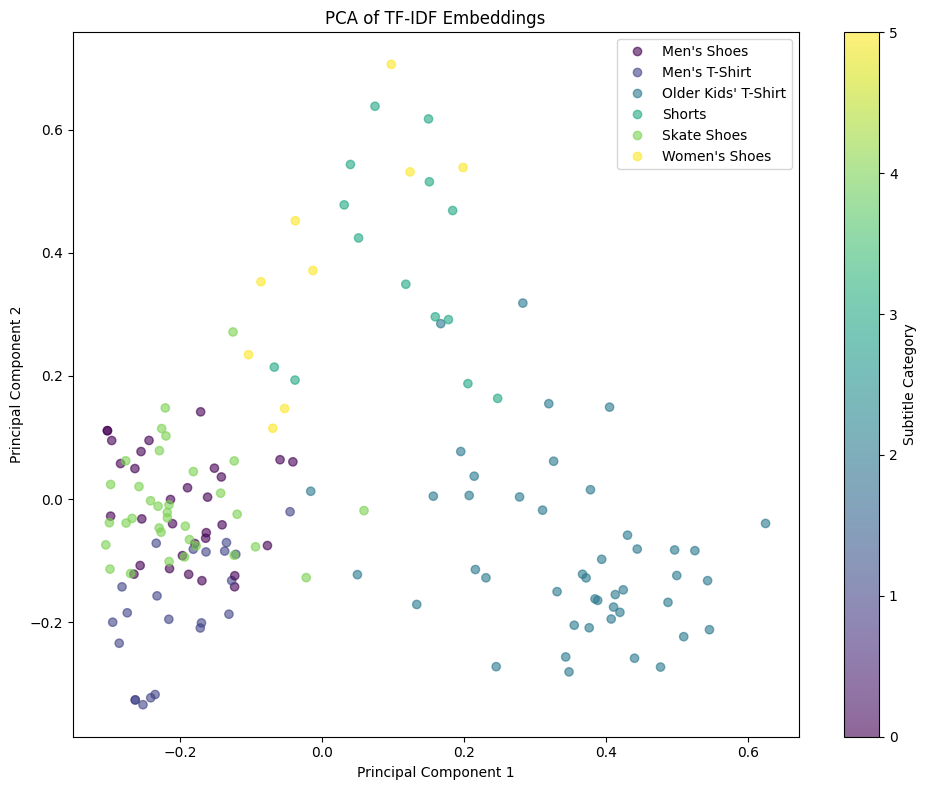

TF-IDF - Variance explained by first two components: 12.61%


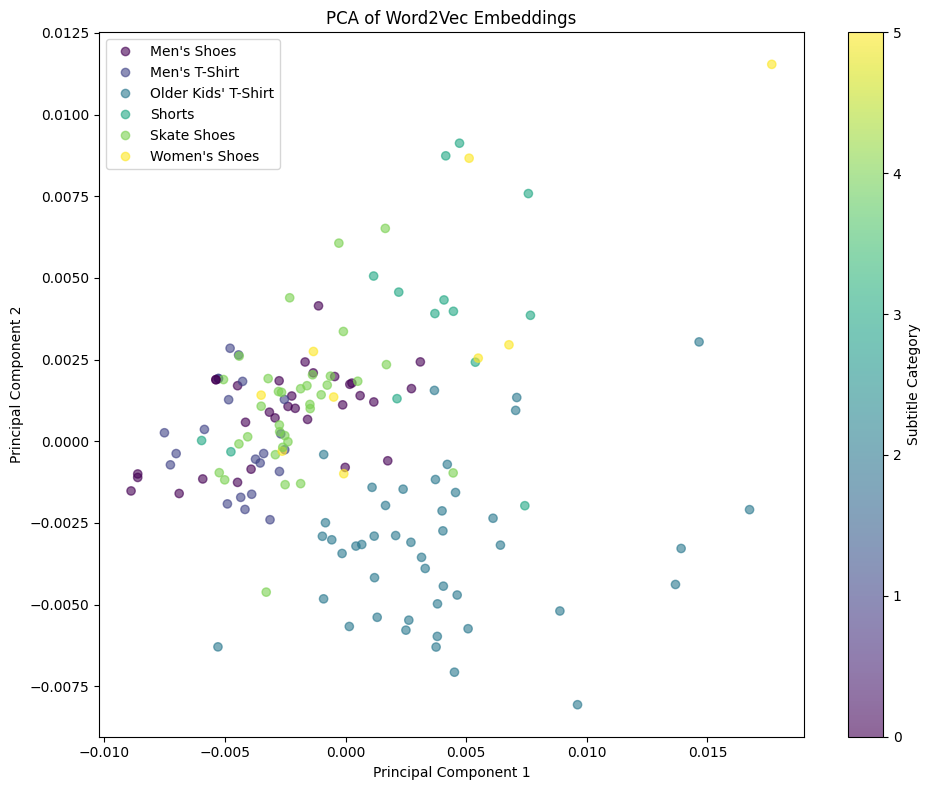

Word2Vec - Variance explained by first two components: 18.68%


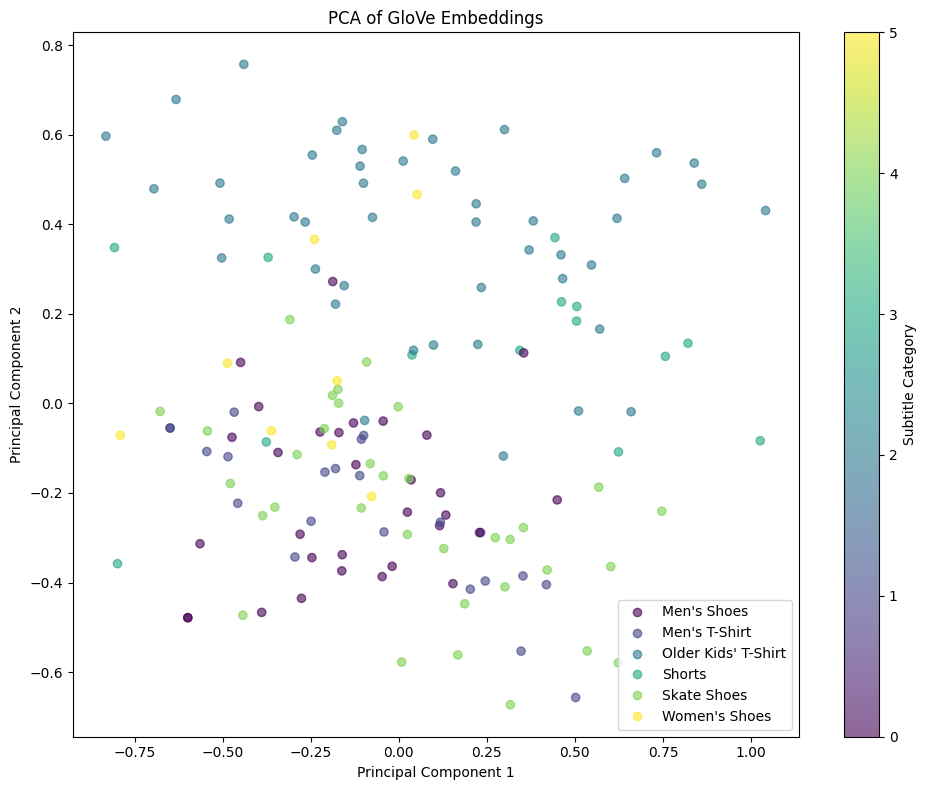

GloVe - Variance explained by first two components: 24.46%


In [37]:
# PCA and visualization for each embedding method
def perform_pca_and_plot(matrix, title, subtitle_col):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(matrix)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=pd.factorize(subtitle_col)[0], alpha=0.6)
    plt.title(f'PCA of {title} Embeddings')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar(scatter, label='Subtitle Category')
    plt.legend(handles=scatter.legend_elements()[0], labels=sorted(subtitle_col.unique()))
    plt.tight_layout()
    plt.savefig(f'pca_{title.lower().replace(" ", "_")}.png')
    plt.show()
    plt.close()

    # Calculate the variance explained by the first two components
    explained_variance = pca.explained_variance_ratio_
    print(f"{title} - Variance explained by first two components: {sum(explained_variance) * 100:.2f}%")

    # Calculate silhouette score or similar metric to evaluate clustering quality
    # This is a simple approach - higher variance explained is better
    return sum(explained_variance)

# Perform PCA and plotting for each embedding method
print("\nPerforming PCA and visualization...")
bow_score = perform_pca_and_plot(bow_df, 'Bag of Words', df_filtered['Subtitle'])
tfidf_score = perform_pca_and_plot(tfidf_df, 'TF-IDF', df_filtered['Subtitle'])
w2v_score = perform_pca_and_plot(w2v_matrix, 'Word2Vec', df_filtered['Subtitle'])
glove_score = perform_pca_and_plot(glove_matrix, 'GloVe', df_filtered['Subtitle'])

In [40]:
# Compare the embedding methods
print("\nComparison of Embedding Methods:")
methods = ['Bag of Words', 'TF-IDF', 'Word2Vec', 'GloVe']
scores = [bow_score, tfidf_score, w2v_score, glove_score]

for method, score in zip(methods, scores):
    print(f"{method}: Variance Explained = {score * 100:.2f}%")


Comparison of Embedding Methods:
Bag of Words: Variance Explained = 17.56%
TF-IDF: Variance Explained = 12.61%
Word2Vec: Variance Explained = 18.68%
GloVe: Variance Explained = 24.46%


Based on variance explained, the best embedding method is: GloVe

GloVe captures global word co-occurrence statistics.
GloVe embeddings are pre-trained on large corpora and provide rich semantic representations.

Conclusion:
The GloVe embedding method performs best for this dataset because it captures the most variance in the first two principal components.
This indicates that this method is most effective at representing the semantic differences between product descriptions of different categories.